In [ ]:
# TABLE {}_sales_record (timestamp text , user_id text, item_id text, amount integer, price real).format(self.account))
# @app.route('/upload4rfm')
# def upload4rfm():
#     pass
@app.route('/sale2rfm', methods = ['POST'])
def sale2rfm():
#     df = 
    headdate = request.form.get('headdate'); taildate = request.form.get('taildate')
    
    try:
        df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y %H:%M'))
        df = df[(df['timestamp']>=headdate)&(df['timestamp']<=taildate)]
    except:
        pass
    
    try:
        taildate = datetime.datetime.strptime(taildate, '%Y-%m-%d')
        df.sort_values(by=['timestamp'],ascending=True,inplace=True)
        df['spend'] = df['amount']*df['price']
        df = df.groupby(by=['timestamp','user_id'],as_index=False).sum()[['timestamp','user_id','spend']]
    except:
        pass
    
    try:    
        df2 = df[['user_id','spend']].groupby(by=['user_id'],as_index=False).sum().rename(columns={'spend':'cost'})
        df1 = df[['timestamp','user_id']].groupby(by=['user_id'],as_index=False).count().rename(columns={'timestamp':'nbtran'})
        df3 = df[['timestamp','user_id']].groupby(by=['user_id'],as_index=False).max().rename(columns={'timestamp':'lasttime'})
        df3['deltaT'] = (taildate - df3['lasttime'])
        df3['deltaT'] = df3['deltaT'].apply(lambda x:x.days)
        df3 = df3[['user_id','deltaT']]
        df = df3.merge(df1,on='user_id');df = df.merge(df2,on='user_id')
    except:
        pass

    return df

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time,datetime
import numpy as np
import sqlite3
from flask import Flask
from flask import request
from flask import jsonify
from flask import session
from flask_cors import CORS
# app = Flask(__name__)
# CORS(app)

# '''導入銷售資料'''

In [2]:
# df = pd.read_csv('data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': int})

# df = df.drop_duplicates()
# df = df[['InvoiceNo','InvoiceDate','CustomerID','StockCode','Quantity','UnitPrice']]
# df.columns = ['tranid','timestamp','user_id','item_id','amount','price']
# df = df.reset_index().drop(['index'],axis=1)
# df.tranid = df.tranid.apply(lambda x: x if 'C' not in x else None)
# df = df.dropna()
# df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y %H:%M'))
# df.to_csv('data2.csv',index=0)
raw_df = pd.read_csv('data2.csv',encoding="ISO-8859-1")

In [3]:
raw_df.tail()

,tranid,timestamp,user_id,item_id,amount,price
392727,581587,2011-12-09 12:50:00,12680,22613,12,0.85
392728,581587,2011-12-09 12:50:00,12680,22899,6,2.10
392729,581587,2011-12-09 12:50:00,12680,23254,4,4.15
392730,581587,2011-12-09 12:50:00,12680,23255,4,4.15
392731,581587,2011-12-09 12:50:00,12680,22138,3,4.95


# '''使用原始銷售資料轉換為RFM模型可用資料 (其中選擇欲使用之時間區段)'''

In [4]:
def dateInterval(df,headdate,taildate):
    df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    df = df[(df['timestamp']>=headdate)&(df['timestamp']<=taildate)]
    return df

def etl(df):
    df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    print('time')
    
    df.sort_values(by=['timestamp'],ascending=True,inplace=True)
    df['spend'] = df['amount']*df['price']
    df = df.groupby(by=['timestamp','user_id'],as_index=False).sum()[['timestamp','user_id','spend']]
    print('group')
    
    user_id = [uid for uid in df.user_id.unique()]
    diff = [pd.DataFrame(df[df['user_id']==uid]['timestamp']).diff() for uid in user_id]
    cycle_mean = [i.mean()[0] for i in diff]
    cycle_median = [i.median()[0] for i in diff]
    rebuy = [i.iloc[-1][0] for i in diff]
    cy_dict = {'user_id':user_id,'cycle_mean':cycle_mean,'cycle_median':cycle_median,'rebuy':rebuy}
    df1 = pd.DataFrame(cy_dict).fillna(0)
    print('cycle')
    
    df2 = df[['timestamp','user_id']].groupby(by=['user_id'],as_index=False).count().rename(columns={'timestamp':'nbtran'})
    df3 = df[['user_id','spend']].groupby(by=['user_id'],as_index=False).sum().rename(columns={'spend':'cost'})
    
    df4 = df[['timestamp','user_id']].groupby(by=['user_id'],as_index=False).max().rename(columns={'timestamp':'lasttime'})
    df5 = df[['timestamp','user_id']].groupby(by=['user_id'],as_index=False).min().rename(columns={'timestamp':'firsttime'})
    
    taildate = df.timestamp.max().date()
    df4['lasttime'] = df4['lasttime'].apply(lambda x:x.date())
    df5['firsttime'] = df5['firsttime'].apply(lambda x:x.date())
    df4['deltaT'] = (taildate - df4['lasttime'])
    df4['deltaT'] = df4['deltaT'].apply(lambda x:x.days)
    print('RFM')
    
    df = df1.merge(df2,on='user_id');df = df.merge(df3,on='user_id');df = df.merge(df4,on='user_id');df = df.merge(df5,on='user_id')
    df = df[['user_id','cycle_mean','cycle_median','rebuy','deltaT','nbtran','cost','firsttime','lasttime']]
    df['L'] = (df['lasttime'] - df['firsttime']).apply(lambda x: x.days)+1
    return df

In [5]:
s=time.time()
# raw_df = dateInterval(raw_df,'2010-12-01','2011-11-30')
df = etl(raw_df)
e=time.time()
print(e-s)

time
group


C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


cycle
RFM
12.194101333618164


In [6]:
df

,user_id,cycle_mean,cycle_median,rebuy,deltaT,nbtran,cost,firsttime,lasttime,L
0,17850,0 days 00:58:09.375000,0 days 00:01:00,0 days 00:01:00,372,33,5391.21,2010-12-01,2010-12-02,2
1,13047,42 days 18:26:30,46 days 01:53:30,25 days 00:51:00,31,9,3237.54,2010-12-01,2011-11-08,343
2,12583,26 days 11:57:17.142857,23 days 11:29:00,15 days 20:51:00,2,15,7281.38,2010-12-01,2011-12-07,372
3,13748,92 days 16:15:00,127 days 01:13:00,136 days 19:15:00,95,4,948.25,2010-12-01,2011-09-05,279
4,15100,20 days 00:43:00,20 days 00:43:00,32 days 22:26:00,333,3,876.00,2010-12-01,2011-01-10,41
5,15291,24 days 20:40:42.857142,11 days 12:56:00,6 days 21:05:00,25,15,4668.30,2010-12-01,2011-11-14,349
6,14688,18 days 07:20:27,14 days 12:00:30,0 days 00:02:00,7,21,5579.10,2010-12-01,2011-12-02,367
7,15311,4 days 03:29:32.666666,3 days 22:37:30,2 days 23:01:00,0,91,60632.75,2010-12-01,2011-12-09,374
8,17809,32 days 11:12:32.727272,39 days 21:48:00,0 days 00:07:00,16,12,5411.91,2010-12-01,2011-11-23,358
9,16098,40 days 20:36:17.142857,40 days 16:54:00,40 days 16:54:00,87,8,2005.63,2010-12-01,2011-09-13,287


# '''傳統RFM模型 RFM個別以第q百分位數區分為兩塊 分為八種顧客類型'''

In [7]:
def RFM_cate(df,q=50):
    for i in range(df['deltaT'].count()):
        if (df.deltaT[i]>np.percentile(df.deltaT,q)):
            df.loc[i,'R'] = 0
        else:
            df.loc[i,'R'] = 1
    
    for i in range(df['nbtran'].count()):
        if (df.nbtran[i]>np.percentile(df.nbtran,q)):
            df.loc[i,'F'] = 1
        else:
            df.loc[i,'F'] = 0
    
    for i in range(df['cost'].count()):
        if (df.cost[i]>np.percentile(df.cost,q)):
            df.loc[i,'M'] = 1
        else:
            df.loc[i,'M'] = 0
    
    for i in range(df['cost'].count()):
        if (df.R[i]==1)&(df.F[i]==1)&(df.M[i]==1):
            df.loc[i,'客戶類型'] = '重要價值客戶'
        elif (df.R[i]==0)&(df.F[i]==1)&(df.M[i]==1):
            df.loc[i,'客戶類型'] = '重要喚回客戶'
        elif (df.R[i]==1)&(df.F[i]==0)&(df.M[i]==1):
            df.loc[i,'客戶類型'] = '重要深耕客戶'
        elif (df.R[i]==0)&(df.F[i]==0)&(df.M[i]==1):
            df.loc[i,'客戶類型'] = '重要挽留客戶'
        elif (df.R[i]==1)&(df.F[i]==1)&(df.M[i]==0):
            df.loc[i,'客戶類型'] = '潛力客戶'
        elif (df.R[i]==1)&(df.F[i]==0)&(df.M[i]==0):
            df.loc[i,'客戶類型'] = '新客戶'
        elif (df.R[i]==0)&(df.F[i]==1)&(df.M[i]==0):
            df.loc[i,'客戶類型'] = '一般維持客戶'
        elif (df.R[i]==0)&(df.F[i]==0)&(df.M[i]==0):
            df.loc[i,'客戶類型'] = '流失客戶'
    return df

In [8]:
s =time.time()
df = RFM_cate(df,70)
e = time.time()
print(e-s)
df.head()

10.959340333938599


,user_id,cycle_mean,cycle_median,rebuy,deltaT,nbtran,cost,firsttime,lasttime,L,R,F,M,客戶類型
0,17850,0 days 00:58:09.375000,0 days 00:01:00,0 days 00:01:00,372,33,5391.21,2010-12-01,2010-12-02,2,0.0,1.0,1.0,重要喚回客戶
1,13047,42 days 18:26:30,46 days 01:53:30,25 days 00:51:00,31,9,3237.54,2010-12-01,2011-11-08,343,1.0,1.0,1.0,重要價值客戶
2,12583,26 days 11:57:17.142857,23 days 11:29:00,15 days 20:51:00,2,15,7281.38,2010-12-01,2011-12-07,372,1.0,1.0,1.0,重要價值客戶
3,13748,92 days 16:15:00,127 days 01:13:00,136 days 19:15:00,95,4,948.25,2010-12-01,2011-09-05,279,1.0,0.0,0.0,新客戶
4,15100,20 days 00:43:00,20 days 00:43:00,32 days 22:26:00,333,3,876.00,2010-12-01,2011-01-10,41,0.0,0.0,0.0,流失客戶


# '''計算各個顧客類型之人數,價值'''

In [9]:
df_cate2 = df.groupby(by='客戶類型')[['cost']].median().rename(columns={'cost':'median'})
df_cate3 = df.groupby(by='客戶類型')[['cost']].count().rename(columns={'cost':'count'})
df_cate4 = df.groupby(by='客戶類型')[['cost']].sum().rename(columns={'cost':'sum'})
ab = pd.concat([df_cate2,df_cate3,df_cate4], axis=1)
ab = ab.loc[['潛力客戶','新客戶','一般維持客戶','流失客戶','重要價值客戶','重要喚回客戶','重要深耕客戶','重要挽留客戶']]

In [10]:
ab

,median,count,sum
客戶類型,,,
潛力客戶,1032.58,165,162553.750
新客戶,468.41,1687,904624.193
一般維持客戶,824.10,20,15607.650
流失客戶,307.90,1165,441995.000
重要價值客戶,3100.09,901,6064547.610
重要喚回客戶,2812.69,26,86497.350
重要深耕客戶,1898.52,289,866839.920
重要挽留客戶,1750.48,86,344543.421


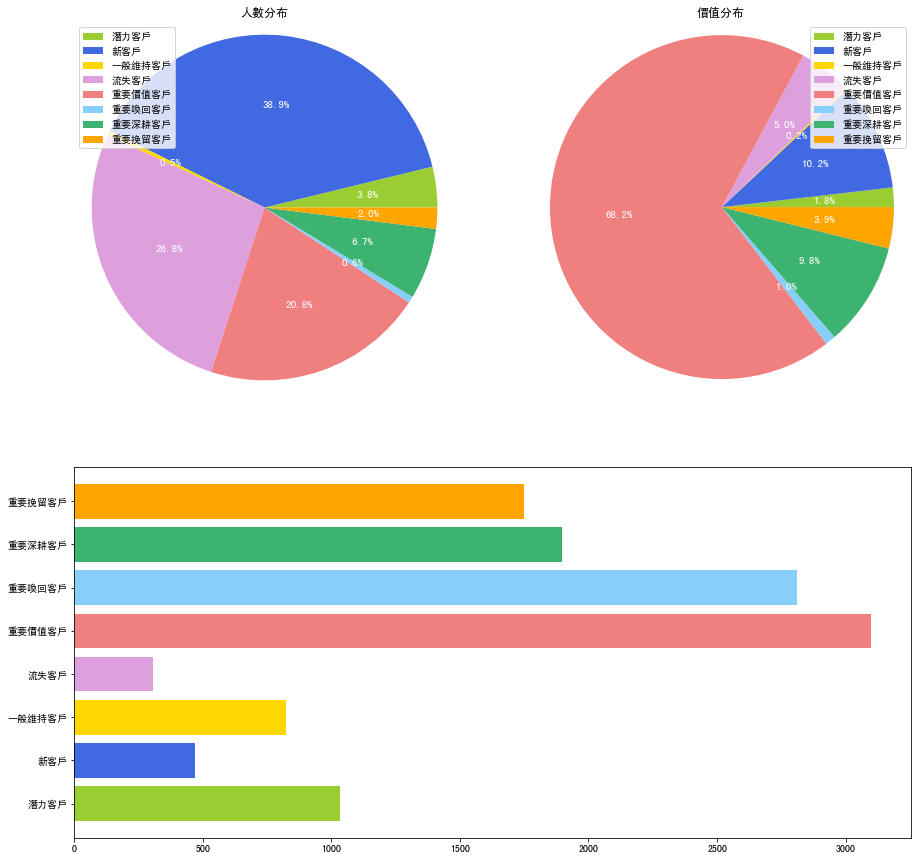

In [11]:
# plt.rcParams['font.sans-serif'] = ['Simhei']
# print(plt.style.available)
plt.figure(10,figsize = (15, 15))
colors = ['yellowgreen', 'royalblue', 'gold', 'plum','lightcoral','lightskyblue','mediumseagreen','orange']
plt.subplot(221)
plt.pie(ab['count'],autopct='%1.1f%%', textprops={'fontsize': 11, 'color': 'w'},colors=colors) 
plt.axis('equal') 
plt.legend(loc='upper left',labels = list(ab.index))
plt.title('人數分布')

plt.subplot(222)
plt.pie(ab['sum'],autopct='%1.1f%%', textprops={'fontsize': 11, 'color': 'w'},colors=colors) 
plt.axis('equal')
plt.legend(loc='upper right',labels = list(ab.index))
plt.title('價值分布')

plt.subplot(212)
plt.barh(ab.index,ab['median'],color=colors)
# plt.legend(labels = ab.index)
plt.show()

# '''以人數為基準 分別對RFM做N等分 並給予加總分數()'''


In [11]:
def RFM_percent(df,n=5):
    b = df.cost.count()//n
    df = df.sort_values(by=['deltaT'],ascending=False).reset_index(drop=True)
    for j in range(n):
        for i in range(b):
            df.loc[i+j*b,'Rs']=1+j
            
    df = df.sort_values(by=['cost']).reset_index(drop=True)
    for j in range(n):
        for i in range(b):
            df.loc[i+j*b,'Fs']=1+j
            
    df = df.sort_values(by=['nbtran']).reset_index(drop=True)
    for j in range(n):
        for i in range(b):
            df.loc[i+j*b,'Ms']=1+j
            
    df = df.fillna(1)
    df['score']=df['Rs']+df['Ms']+df['Fs']
    df.sort_values(by='score',inplace=True)
    return df

In [12]:
s =time.time()
df = RFM_percent(df,5)
e = time.time()
print(e-s)
df.head()

4.858785390853882


,user_id,cycle_mean,cycle_median,rebuy,deltaT,nbtran,cost,firsttime,lasttime,L,R,F,M,客戶類型,Rs,Fs,Ms,score
268,17060,0 days,0 days,0 days,266,1,234.24,2011-03-18,2011-03-18,1,0.0,0.0,0.0,流失客戶,1.0,1.0,1.0,3.0
247,16583,0 days,0 days,0 days,373,1,233.45,2010-12-01,2010-12-01,1,0.0,0.0,0.0,流失客戶,1.0,1.0,1.0,3.0
280,16756,0 days,0 days,0 days,214,1,239.40,2011-05-09,2011-05-09,1,0.0,0.0,0.0,流失客戶,1.0,1.0,1.0,3.0
820,17972,0 days,0 days,0 days,241,1,135.19,2011-04-12,2011-04-12,1,0.0,0.0,0.0,流失客戶,1.0,1.0,1.0,3.0
278,13570,0 days,0 days,0 days,243,1,239.49,2011-04-10,2011-04-10,1,0.0,0.0,0.0,流失客戶,1.0,1.0,1.0,3.0


# '''算出個別分數之人數'''

[ 64 503 334 416 410 343 363 325 348 314 277 301 341]


<BarContainer object of 13 artists>

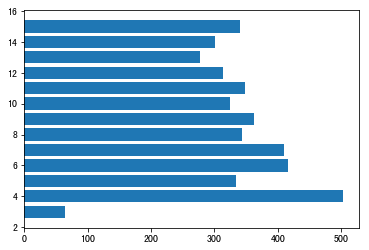

In [13]:
df_percent2 = df.groupby(by='score').size()
print(df_percent2.values)
plt.barh(df_percent2.index,df_percent2)

# '''計算各區間顧客之人數，價值'''

In [14]:
df_means = df.groupby(by=['Rs','Fs'])[['cost']].mean().rename(columns={'cost':'means'}).sort_values(['Rs','Fs'],ascending=True)
means = df_means.means.values.reshape(5,5)/df.groupby(by=['Rs','Fs'])[['cost']].mean().sum()[0]


df_NB = df.groupby(by=['Rs','Fs'])[['cost']].count().rename(columns={'cost':'NB'}).sort_values(['Rs','Fs'],ascending=True)
NB = df_NB.NB.values.reshape(5,5)/df.groupby(by=['Rs','Fs'])[['cost']].count().sum()[0]

df_heat = df.groupby(by=['Rs','Fs'])[['cost']].sum().rename(columns={'cost':'M'}).sort_values(['Rs','Fs'],ascending=True)
heat = df_heat.M.values.reshape(5,5)/df.groupby(by=['Rs','Fs'])[['cost']].sum().sum()[0]

In [15]:
pd.concat([df_NB,df_means,df_heat],axis=1).reset_index().transpose()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Rs,1.000000,1.00000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000e+00,5.000000,5.000000,5.000000,5.000000,5.000000e+00
Fs,1.000000,2.00000,3.000000,4.000000,5.000000,1.000000,2.000000,3.000000,4.000000,5.000000,...,1.000000,2.000000,3.000000,4.000000,5.000000e+00,1.000000,2.000000,3.000000,4.000000,5.000000e+00
NB,362.000000,282.00000,136.000000,68.000000,23.000000,179.000000,197.000000,233.000000,177.000000,81.000000,...,106.000000,136.000000,175.000000,225.000000,2.250000e+02,63.000000,79.000000,123.000000,210.000000,3.920000e+02
means,147.332072,347.60305,659.215074,1334.410441,14042.685261,149.223799,357.280005,673.986742,1367.630734,3572.792099,...,149.816981,358.865515,695.655543,1400.052933,5.510178e+03,14488.490317,366.046456,707.070407,1436.710476,8.249584e+03
M,53334.210000,98024.06000,89653.250000,90739.910000,322981.761000,26711.060000,70384.161000,157038.911000,242070.640000,289396.160000,...,15880.600000,48805.710000,121739.720000,315011.910000,1.239790e+06,912774.890000,28917.670000,86969.660000,301709.200000,3.233837e+06


Text(89.0, 0.5, 'R')

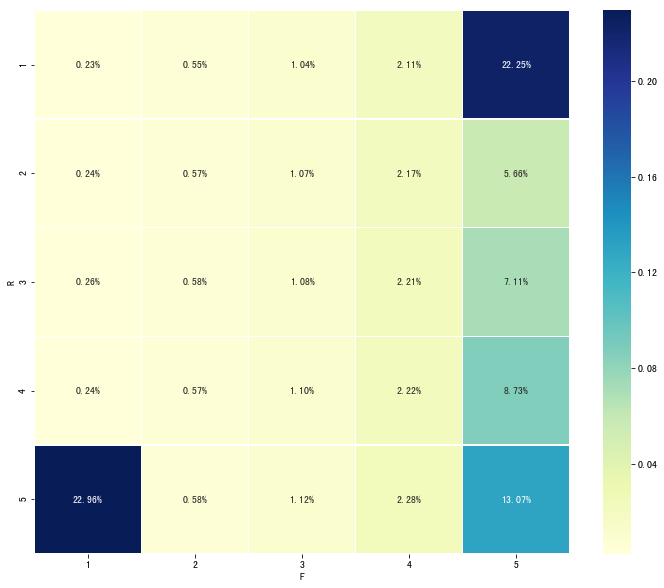

In [16]:
import seaborn as sns
# sns.set()
fig = plt.figure(figsize = (12,10))
ax = sns.heatmap(means ,cmap="YlGnBu",annot=True,fmt ='.2%',linewidths=0.2,xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])
plt.xlabel('F');plt.ylabel('R')

Text(89.0, 0.5, 'R')

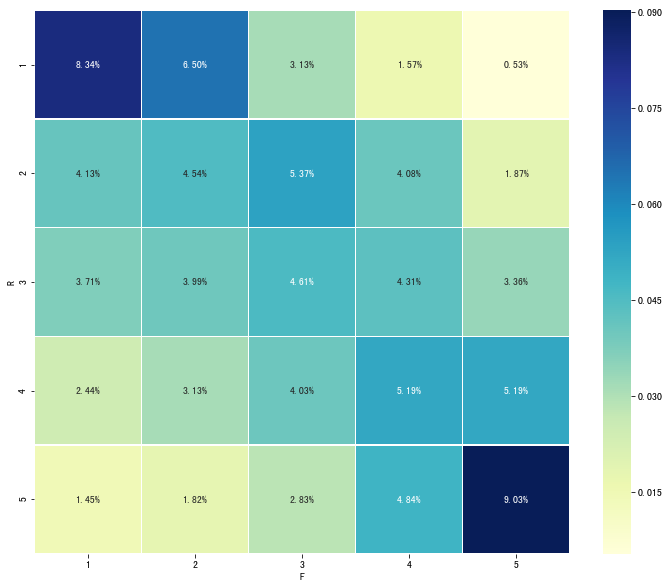

In [17]:
import seaborn as sns
# sns.set()
fig = plt.figure(figsize = (12,10))
ax = sns.heatmap(NB ,cmap="YlGnBu",annot=True,fmt ='.2%',linewidths=0.2,xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])
plt.xlabel('F');plt.ylabel('R')

Text(89.0, 0.5, 'R')

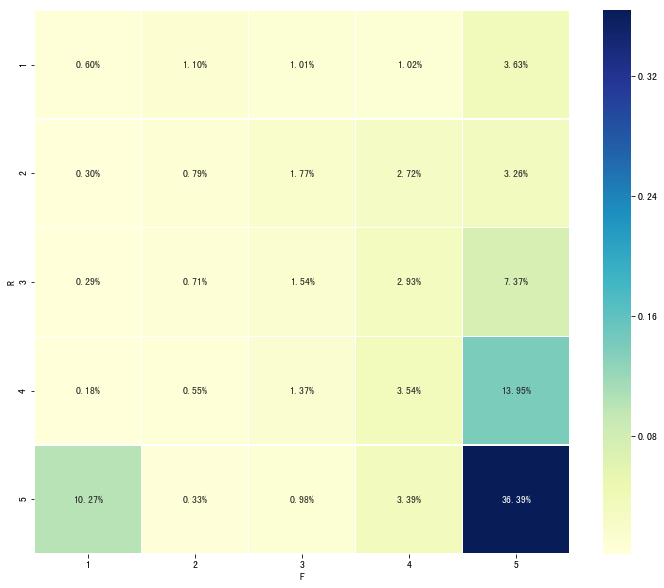

In [18]:
import seaborn as sns
# sns.set()
fig = plt.figure(figsize = (12,10))
ax = sns.heatmap(heat ,cmap="YlGnBu",annot=True,fmt ='.2%',linewidths=0.2,xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])
plt.xlabel('F');plt.ylabel('R')

# '''加入L之RLFM模型顧客分群'''

In [19]:
def Lmodel(df,L=180,R=90,F=2):
    for i in range(df['L'].count()):
        if (df.L[i]>L):
            if (df.deltaT[i]>R):
                if (df.nbtran[i]>F):
                    df.loc[i,'客戶類型2'] = '好久沒來的老客戶'
                else:
                    df.loc[i,'客戶類型2'] = '失去的老客戶'
            else:
                if (df.nbtran[i]>F):
                    df.loc[i,'客戶類型2'] = '忠誠的老客戶'
                else:
                    df.loc[i,'客戶類型2'] = '普通的老客戶'
        else:
            if (df.deltaT[i]>R):
                df.loc[i,'客戶類型2'] = '一次性客戶'
            else:
                df.loc[i,'客戶類型2'] = '新客戶'
    return df

In [20]:
s =time.time()
df = Lmodel(df,90,30,2)
e = time.time()
print(e-s)
df.head()

2.8174524307250977


,user_id,cycle_mean,cycle_median,rebuy,deltaT,nbtran,cost,firsttime,lasttime,L,R,F,M,客戶類型,Rs,Fs,Ms,score,客戶類型2
268,17060,0 days,0 days,0 days,266,1,234.24,2011-03-18,2011-03-18,1,0.0,0.0,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶
247,16583,0 days,0 days,0 days,373,1,233.45,2010-12-01,2010-12-01,1,0.0,0.0,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶
280,16756,0 days,0 days,0 days,214,1,239.40,2011-05-09,2011-05-09,1,0.0,0.0,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶
820,17972,0 days,0 days,0 days,241,1,135.19,2011-04-12,2011-04-12,1,0.0,0.0,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶
278,13570,0 days,0 days,0 days,243,1,239.49,2011-04-10,2011-04-10,1,0.0,0.0,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶


In [21]:
df['cost_mean'] = df.cost/df.nbtran

In [22]:
for i in range(df['nbtran'].count()):
    if df.nbtran.loc[i]==1:  
        df.loc[i,'nes'] = 0
        df.loc[i,'nes2'] = 0
    else:
        df.loc[i,'nes'] = df.loc[i,'rebuy']/df.loc[i,'cycle_mean']
        df.loc[i,'nes2'] = df.loc[i,'rebuy']/df.loc[i,'cycle_median']

In [23]:
df

,user_id,cycle_mean,cycle_median,rebuy,deltaT,nbtran,cost,firsttime,lasttime,L,...,M,客戶類型,Rs,Fs,Ms,score,客戶類型2,cost_mean,nes,nes2
268,17060,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,266,1,234.24,2011-03-18,2011-03-18,1,...,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶,234.240000,0.000000,0.000000
247,16583,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,373,1,233.45,2010-12-01,2010-12-01,1,...,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶,233.450000,0.000000,0.000000
280,16756,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,214,1,239.40,2011-05-09,2011-05-09,1,...,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶,239.400000,0.000000,0.000000
820,17972,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,241,1,135.19,2011-04-12,2011-04-12,1,...,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶,135.190000,0.000000,0.000000
278,13570,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,243,1,239.49,2011-04-10,2011-04-10,1,...,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶,239.490000,0.000000,0.000000
843,15350,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,373,1,115.65,2010-12-01,2010-12-01,1,...,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶,115.650000,0.000000,0.000000
207,18009,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,235,1,247.39,2011-04-18,2011-04-18,1,...,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶,247.390000,0.000000,0.000000
274,17051,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,194,1,240.89,2011-05-29,2011-05-29,1,...,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶,240.890000,0.000000,0.000000
860,16913,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,290,1,113.44,2011-02-22,2011-02-22,1,...,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶,113.440000,0.000000,0.000000
805,14890,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,253,1,125.65,2011-03-31,2011-03-31,1,...,0.0,流失客戶,1.0,1.0,1.0,3.0,一次性客戶,125.650000,0.000000,0.000000


# '''計算各區間顧客之價值'''

In [24]:
costsum = df.groupby(by=(['客戶類型2']))[['cost']].sum().rename(columns={'cost':'cost_sum'})
costmedian = df.groupby(by=(['客戶類型2']))[['cost']].median().rename(columns={'cost':'cost_median'})
costcount = df.groupby(by=(['客戶類型2']))[['cost']].count().rename(columns={'cost':'count'})
abc = pd.concat([costsum,costmedian,costcount], axis=1)
abc.transpose()

客戶類型2,一次性客戶,失去的老客戶,好久沒來的老客戶,忠誠的老客戶,新客戶,普通的老客戶
cost_sum,913932.182,206117.920,1476424.952,5692536.15,351321.64,246876.050
cost_median,312.680,601.035,1340.870,2263.12,433.86,463.945
count,1660.000,286.000,725.000,1053.00,485.00,130.000


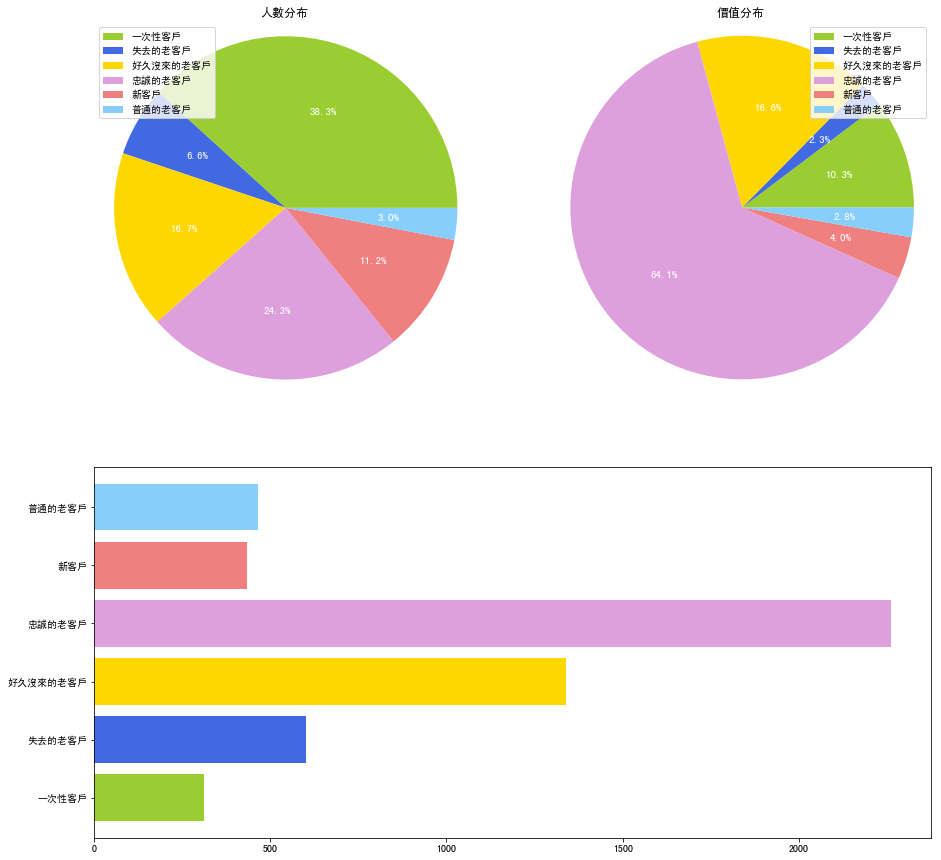

In [25]:
# plt.rcParams['font.sans-serif'] = ['Simhei']
plt.figure(10,figsize = (15, 15))
colors = ['yellowgreen', 'royalblue', 'gold', 'plum','lightcoral','lightskyblue','mediumseagreen','orange']
plt.subplot(221)
plt.pie(abc['count'],autopct='%1.1f%%', textprops={'fontsize': 11, 'color': 'w'},colors=colors) 
plt.axis('equal') 
plt.legend(loc='upper left',labels = list(abc.index))
plt.title('人數分布')

plt.subplot(222)
plt.pie(abc['cost_sum'],autopct='%1.1f%%', textprops={'fontsize': 11, 'color': 'w'},colors=colors) 
plt.axis('equal')
plt.legend(loc='upper right',labels = list(abc.index))
plt.title('價值分布')

plt.subplot(212)
plt.barh(abc.index,abc['cost_median'],color=colors)
# plt.legend(labels = ab.index)
plt.show()

# '''RLFM視覺化模型'''

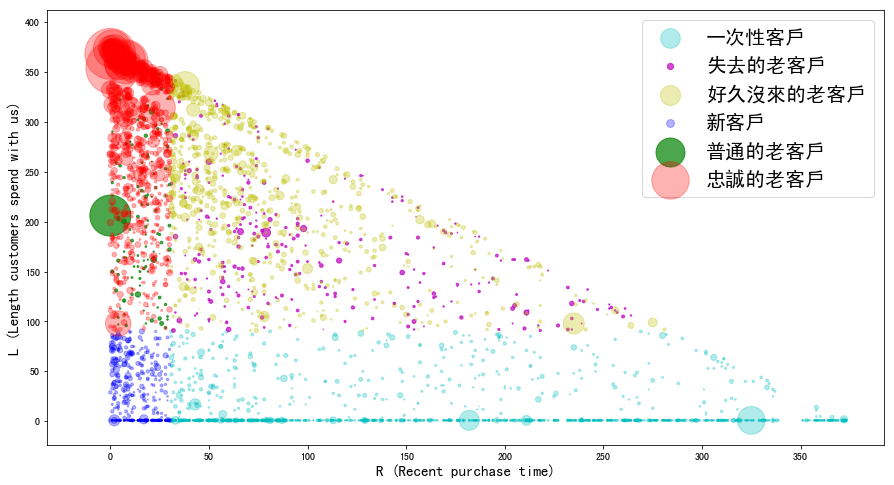

In [26]:
fig = plt.figure(figsize = (15,8))
cm = plt.cm.get_cmap('RdYlBu')

df1=df[df['客戶類型2']=='一次性客戶'];df4=df[df['客戶類型2']=='新客戶']
df2=df[df['客戶類型2']=='失去的老客戶'];df5=df[df['客戶類型2']=='普通的老客戶']
df3=df[df['客戶類型2']=='好久沒來的老客戶'];df6=df[df['客戶類型2']=='忠誠的老客戶']

c = plt.scatter(df1.deltaT,df1.L,s=(df1.cost - np.min(df1.cost)) * 0.01,alpha=0.3,c='c')
m = plt.scatter(df2.deltaT,df2.L,s=(df2.cost - np.min(df2.cost)) * 0.01,alpha=0.7,c='m')
y = plt.scatter(df3.deltaT,df3.L,s=(df3.cost - np.min(df3.cost)) * 0.01,alpha=0.3,c='y')
b = plt.scatter(df4.deltaT,df4.L,s=(df4.cost - np.min(df4.cost)) * 0.01,alpha=0.3,c='b')
g = plt.scatter(df5.deltaT,df5.L,s=(df5.cost - np.min(df5.cost)) * 0.01,alpha=0.7,c='g')
r = plt.scatter(df6.deltaT,df6.L,s=(df6.cost - np.min(df6.cost)) * 0.01,alpha=0.3,c='r')

# p = plt.hlines(90, 0, 365, "k", linestyles='dashed') 
# p2 = plt.vlines(30, 0, 365, "k", linestyles='dashed') 
# x = np.linspace(0,365,2)
# plt.plot(x, -x+365, linestyle='dashed')
# plt.gca().invert_xaxis()
plt.legend((c, m, y, b, g, r),('一次性客戶', '失去的老客戶', '好久沒來的老客戶', '新客戶', '普通的老客戶', '忠誠的老客戶'),fontsize=20)

plt.xlabel('R (Recent purchase time)', fontsize = 15)#X轴标签
plt.ylabel('L (Length customers spend with us)', fontsize = 15)#Y轴标签

plt.show()

In [27]:
def plotkindtrend():
#     df = df.set_index('user_id')
#     df.head()
    for kind in df['客戶類型2'].unique():
        indexlist = df[df['客戶類型2']==kind]['user_id'].values

        loyalcus = raw_df[raw_df['user_id'].isin(indexlist)]

        loyalcus.loc[:,'timestamp'] = loyalcus.loc[:,'timestamp'].apply(lambda x:x.month)
        # for i in loyalcus['timestamp'].iloc[0:10]:
        #     print(i.month)
        loyalcus = loyalcus.groupby(by='timestamp').sum()['spend']
        
        
        plt.plot(loyalcus)

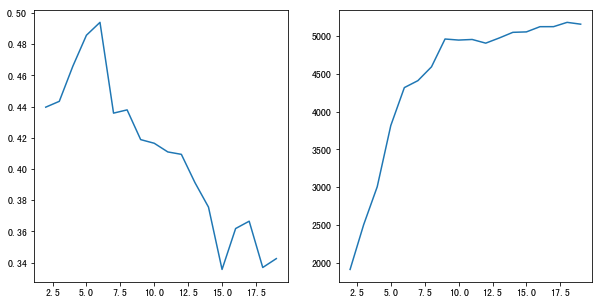

[0.4396583276448002, 0.4433977984302191, 0.4659381186829035, 0.48575462201880204, 0.4940211082716262, 0.4358398626162145, 0.43792310407374324, 0.4188634624189597, 0.41652809485290837, 0.41096782385102393, 0.40942093690298115, 0.3913273738701584, 0.3755970815966415, 0.33564535770981424, 0.361864707693659, 0.3665675554583176, 0.3368973125105927, 0.3425860955138574] [1909.8021451313266, 2502.560640888908, 3005.4409496504218, 3816.4504049652774, 4319.586678913498, 4411.785622725673, 4594.50386599843, 4963.593436706497, 4949.4900523430615, 4957.47642264276, 4908.696213333366, 4977.331982741922, 5051.976595995513, 5057.83835544968, 5126.809275105879, 5127.204587209153, 5184.253176973318, 5160.048470637102]


In [28]:
from sklearn import cluster, metrics, preprocessing
df.deltaT = df.deltaT.astype(float)                   
df.nbtran = df.nbtran.astype(float)
df.cost_mean = df.cost_mean.astype(float)
df.L = df.L.astype(float)

X = df[['deltaT','nbtran','cost_mean','L']].values
X = preprocessing.scale(X)

silhouette_avgs = []
calinski_harabaz_scores = []
ks = range(2, 20)

for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(X)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    calinski_harabaz_score = metrics.calinski_harabaz_score(X, cluster_labels) 
    calinski_harabaz_scores.append(calinski_harabaz_score)
# 作圖並印出 k = 2 到 10 的績效
plt.figure(1,figsize = (10, 5))
plt.subplot(121)
plt.plot(ks, silhouette_avgs)
plt.subplot(122)
plt.plot(ks,calinski_harabaz_scores)
plt.show()
print(silhouette_avgs,calinski_harabaz_scores)

In [29]:
print('群數:',silhouette_avgs.index(max(silhouette_avgs))+2,'\n','分數:',max(silhouette_avgs))
print('群數:',calinski_harabaz_scores.index(max(calinski_harabaz_scores))+2,'\n','分數:',max(calinski_harabaz_scores))

群數: 6 
 分數: 0.4940211082716262
群數: 18 
 分數: 5184.253176973318


In [30]:
kmeans_fit = cluster.KMeans(n_clusters=6).fit(X)
cluster_labels = kmeans_fit.labels_

In [31]:
df['Kmean']=cluster_labels

In [32]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# fig = plt.figure(figsize = (12,10))
# cm = plt.cm.get_cmap('RdYlBu')

df1=df[df['Kmean']==0];df4=df[df['Kmean']==3]#;df7=df[df['Kmean']==6]
df2=df[df['Kmean']==1];df5=df[df['Kmean']==4]#;df8=df[df['Kmean']==7]
df3=df[df['Kmean']==2];df6=df[df['Kmean']==5]#;df9=df[df['Kmean']==8]

# c = go.scatter(x=df1.deltaT,y=df1.L,s=(df1.cost - np.min(df1.cost)) * 0.01,alpha=0.3,c='c')
# m = go.scatter(x=df2.deltaT,y=df2.L,s=(df2.cost - np.min(df2.cost)) * 0.01,alpha=0.7,c='m')
# y = go.scatter(x=df3.deltaT,y=df3.L,s=(df3.cost - np.min(df3.cost)) * 0.01,alpha=0.3,c='y')
# b = go.scatter(x=df4.deltaT,y=df4.L,s=(df4.cost - np.min(df4.cost)) * 0.01,alpha=0.3,c='b')
# g = go.scatter(x=df5.deltaT,y=df5.L,s=(df5.cost - np.min(df5.cost)) * 0.01,alpha=0.7,c='g')
# r = go.scatter(x=df6.deltaT,y=df6.L,s=(df6.cost - np.min(df6.cost)) * 0.01,alpha=0.3,c='r')

c = go.Scatter(x=df1.deltaT,y=df1.L,mode = 'markers',opacity=.7)
m = go.Scatter(x=df2.deltaT,y=df2.L,mode = 'markers',opacity=.7)
y = go.Scatter(x=df3.deltaT,y=df3.L,mode = 'markers',opacity=.7)
b = go.Scatter(x=df4.deltaT,y=df4.L,mode = 'markers',opacity=.7)
g = go.Scatter(x=df5.deltaT,y=df5.L,mode = 'markers',opacity=.7)
r = go.Scatter(x=df6.deltaT,y=df6.L,mode = 'markers',opacity=.7)
#v = go.Scatter(x=df7.deltaT,y=df7.L,mode = 'markers',opacity=.7)
#x = go.Scatter(x=df8.deltaT,y=df8.L,mode = 'markers',opacity=.7)
#a = go.Scatter(x=df9.deltaT,y=df9.L,mode = 'markers',opacity=.7)
# colorscale='Viridis'

# p3 = plt.hlines(150, 0, 150, "k", linestyles='dashed') 
# p4 = plt.vlines(150, 0, 150, "k", linestyles='dashed') 
# x = np.linspace(150,190,2)
# plt.plot(x, x, linestyle='dashed')
# plt.legend((c, m, y, b, g, r),('0', '1', '2', '3', '4', '5'),fontsize=20)

# # plt.xlabel('R (Recent purchase time)', fontsize = 15)#X轴标签
# plt.ylabel('L (Length customers spend with us)', fontsize = 15)#Y轴标签

# plt.show()
# py.iplot([c,m])
py.iplot([c,m,y,b,g,r])

In [33]:
df[df['Kmean']==2]

,user_id,cycle_mean,cycle_median,rebuy,deltaT,nbtran,cost,firsttime,lasttime,L,...,客戶類型,Rs,Fs,Ms,score,客戶類型2,cost_mean,nes,nes2,Kmean
1024,12346,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,325.0,1.0,77183.6,2011-01-18,2011-01-18,1.0,...,重要挽留客戶,1.0,5.0,2.0,8.0,一次性客戶,77183.60,0.0,0.0,2
2325,16446,204 days 23:23:00,204 days 23:23:00,204 days 23:23:00,0.0,2.0,168472.5,2011-05-18,2011-12-09,206.0,...,重要深耕客戶,5.0,1.0,3.0,9.0,普通的老客戶,84236.25,1.0,1.0,2


In [35]:
df[df['Kmean']==3]

,user_id,cycle_mean,cycle_median,rebuy,deltaT,nbtran,cost,firsttime,lasttime,L,...,客戶類型,Rs,Fs,Ms,score,客戶類型2,cost_mean,nes,nes2,Kmean
4338,12748,1 days 18:37:34.857142,0 days 19:41:00,0 days 16:19:00,0.0,211.0,33053.19,2010-12-01,2011-12-09,374.0,...,重要價值客戶,1.0,5.0,1.0,7.0,忠誠的老客戶,156.650190,0.382784,0.828959,3
4335,14606,3 days 23:00:19.787234,3 days 22:50:00,2 days 06:32:00,1.0,95.0,12076.15,2010-12-01,2011-12-08,373.0,...,重要價值客戶,5.0,5.0,1.0,11.0,忠誠的老客戶,127.117368,0.574002,0.575044,3
4336,17841,3 days 00:33:52.195121,2 days 22:50:00,1 days 21:44:00,1.0,124.0,40519.84,2010-12-01,2011-12-08,373.0,...,重要價值客戶,5.0,5.0,1.0,11.0,忠誠的老客戶,326.772903,0.630244,0.645647,3
4333,15311,4 days 03:29:32.666666,3 days 22:37:30,2 days 23:01:00,0.0,91.0,60632.75,2010-12-01,2011-12-09,374.0,...,重要價值客戶,1.0,5.0,5.0,11.0,忠誠的老客戶,666.293956,0.713790,0.750506,3
4337,14911,1 days 20:38:56.700000,0 days 22:22:30,1 days 04:12:00,1.0,201.0,143711.17,2010-12-01,2011-12-08,373.0,...,重要價值客戶,5.0,5.0,1.0,11.0,忠誠的老客戶,714.980945,0.631592,1.260335,3
4332,12971,4 days 11:56:48.292682,3 days 21:05:30,4 days 21:39:00,3.0,83.0,11189.91,2010-12-02,2011-12-06,370.0,...,重要價值客戶,5.0,5.0,5.0,15.0,忠誠的老客戶,134.818193,1.089889,1.263808,3
4334,13089,3 days 23:43:25.434782,2 days 05:06:00,1 days 18:32:00,2.0,93.0,58762.08,2010-12-05,2011-12-07,368.0,...,重要價值客戶,5.0,5.0,5.0,15.0,忠誠的老客戶,631.850323,0.444334,0.801004,3


In [ ]:
for i in df.index:
    if df.loc[i,'nbtran']== 1.0 :
         df.loc[i,'nes'] = 0
    else :
        df.loc[i,'nes'] = df.loc[i,'rebuy']/df.loc[i,'cycle_mean']

In [ ]:
for i in df.index:
    if df.loc[i,'nbtran']== 1.0 :
         df.loc[i,'nes'] = 'N'
    elif 1*df.loc[i]['cycle_mean']>df.loc[i]['rebuy']:
        df.loc[i,'nes'] = 'E0'
    elif 2*df.loc[i]['cycle_mean']>df.loc[i]['rebuy']:
        df.loc[i,'nes'] = 'S1'
    elif 3*df.loc[i]['cycle_mean']>df.loc[i]['rebuy']:
        df.loc[i,'nes'] = 'S2'
    else :
        df.loc[i,'nes'] = 'S3'

In [ ]:
df.groupby('nes').size()

In [ ]:
df =df.drop(columns=['E0', 'N', 'S1', 'S2', 'S3'])
df = df.join(pd.get_dummies(df['nes']))
df.columns

In [ ]:
from sklearn import cluster, metrics, preprocessing
df.deltaT = df.deltaT.astype(float)                   
df.nbtran = df.nbtran.astype(float)
df.cost = df.cost.astype(float)
df.L = df.L.astype(float)

X = df[['deltaT','nbtran','cost','L','E0','N','S1','S2','S3']].values
X = preprocessing.scale(X)

silhouette_avgs = []
calinski_harabaz_scores = []
ks = range(2, 10)

for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(X)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    calinski_harabaz_score = metrics.calinski_harabaz_score(X, cluster_labels) 
    calinski_harabaz_scores.append(calinski_harabaz_score)
# 作圖並印出 k = 2 到 10 的績效
plt.figure(1,figsize = (10, 5))
plt.subplot(121)
plt.plot(ks, silhouette_avgs)
plt.subplot(122)
plt.plot(ks,calinski_harabaz_scores)
plt.show()
print(silhouette_avgs,calinski_harabaz_scores)

In [ ]:
'''-------------------------------------------------KMEAN-----------------------------------------------------------------'''

In [ ]:
df.deltaT = df.deltaT.astype(float)                   
df.nbtran = df.nbtran.astype(float)
df.cost = df.cost.astype(float)
df.L = df.L.astype(float)
X = df[['deltaT','nbtran','cost','L']].values
X = preprocessing.scale(X)
df.Kmean = df.Kmean.astype('category')
Y = df.Kmean

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=.5,random_state=501) 
tree = DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=3)
tree.fit(X_train,Y_train)

In [ ]:
error = 0
for i,v in enumerate(tree.predict(X_test)):
    if v!=Y_test[i]:
#         print(i,v)
        error+=1
print(1-(error/i))
    

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
dot_tree = export_graphviz(tree,feature_names=['deltaT','nbtran','cost','L'],out_file='tree.dot',filled=True, rounded=True,special_characters=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV 
from sklearn import cross_validation, metrics
forest = RandomForestClassifier(criterion='entropy',max_depth=10,random_state=4,n_estimators=100,n_jobs=2,oob_score=True)
forest.fit(X_train,Y_train)

In [ ]:
y_pred = tree.predict(X_test)#tree.predict(X_test)#
print(metrics.accuracy_score(Y_test, y_pred))
# print(metrics.confusion_matrix(Y_test, y_pred, labels=[0,1,2,3,4,5]))
target_names = ['0','1','2','3','4','5']
print(metrics.classification_report(Y_test, y_pred,target_names=target_names))
print(metrics.f1_score(Y_test, y_pred,average='micro'),metrics.f1_score(Y_test, y_pred,average='macro'),metrics.f1_score(Y_test, y_pred,average='weighted'))

In [ ]:
error = 0
for i,v in enumerate(y_pred):
    if v!=Y_test[i]:
#         print(i,v)
        error+=1
print(1-(error/i))

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go 
# Create random data with numpy 
import numpy as np 
py.init_notebook_mode(connected=True)
N = 100 
random_x = np.linspace(0, 1, N) #建立0与1之间的等差数,1 
random_y0 = np.random.randn(N)+5 #均值为5的正态分布随机数 
random_y1 = np.random.randn(N) 
random_y2 = np.random.randn(N)-5#均值为-5的正态分布随机数 
# Create traces 
trace0 = go.Scatter( x = random_x, y = random_y0, mode = 'markers', name = 'markers') 
#构造散点图线条1 
trace1 = go.Scatter( x = random_x, y = random_y1, mode = 'lines+markers', name = 'lines+markers') 
trace2 = go.Scatter( x = random_x, y = random_y2, mode = 'lines', name = 'lines') 
data = [trace0, trace1, trace2] 
py.iplot(data, filename='scatter-mode')

In [ ]:
%matplotlib inline 
import plotly.offline as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

N = 1000
random_x = np.random.randn(N)
random_y = np.random.randn(N)

# Create a trace
trace = go.Scatter(
    x = random_x,
    y = random_y,
    mode = 'markers'
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename = 'basic-scatter')

# plot_url = py.plot(data)

利用原有sale_record table 轉換為RFM_MODEL可用模型 [不需要有額外資料型態]
加入 storage、promotion、profit table，改變M的定義，針對不同的銷售指標
加入 瀏覽紀錄，不只是RFM評估消費者
RFM model 1.用RFM三個向度分別辦別大或小(自定義) [產生八大類群，做額外分析]
          2.用RFM三個向度分別分為數等分(自定義) [將每一使用者評分，再去產生群組]
          3.加入新的向度L(客戶長度)，形成RLFM_MODEL(自定義) [比傳統RFM能夠更精準分辨新舊客戶...]
          4.以RLFM_MODEL為基底，用AI機器學習分群演算法(Kmean)產生分群 [比起自定義分群，能夠更精準定義消費者行為差異，減少損失]
          4-1[傳統方式與AI的銜接，以往利用銷售人員的過往經驗定義消費者行為，往往會參雜人為偏見，AI擁有客觀優勢]
          4-2[先以分群演算法方式做出分群，再予以描繪出分群方法，以人為方式修正定義，使得AI分群定義方式更直觀且易於接受]
          5.[分群後的行銷策略] 能夠查看每一群組各個指標(or可視化)，易於了解消費者行為模式，使得行銷策略更準確
          5-1[單一群策略] 觀察單一群種行為，群種標籤，群種推薦，群==人
                        EX:一次性、新消費者經常購買之商品，或結合推薦系統預測可能想要之商品，"處理"那些商品，抓住客戶，轉化為忠誠客戶
                        EX:對於流失客戶，探討消費行為，流失原因，流失預測，預防流失。
                        EX:老客戶......
          5-2[群與群之間的關係] 比較各群之間的差異，以及群與群之間的演化行為，擬定策略，使得較低價值顧客轉化為高價值顧客
          5-3[群與群仿效行為] 尋找優勢群優勢原因，使其他群仿效其行為並創造更多價值
          6.[bonus] 確定分群方法後，導入新會員分群方法。
          7.[效度差異] 後面的各種銷售策略方法，差異皆在分群方式，些微的差異產生巨大的利潤。

In [ ]:
def RFM_define(df,Rinterval1,Rinterval2,Rinterval3,Rinterval4,  
                  Finterval1,Finterval2,Finterval3,Finterval4):#,
#                   Minterval1,Minterval2,Minterval3,Minterval4):
    df = df.copy()
    for i in df['deltaT'].unique():
        if (Rinterval1>=i):
            for j in df[df['deltaT']==i].index:
                df.loc[j,'R'] = 5
        elif (Rinterval2>=i)&(i>Rinterval1):
            for j in df[df['deltaT']==i].index:
                df.loc[j,'R'] = 4
        elif (Rinterval3>=i)&(i>Rinterval2):
            for j in df[df['deltaT']==i].index:
                df.loc[j,'R'] = 3
        elif (Rinterval4>=i)&(i>Rinterval3):
            for j in df[df['deltaT']==i].index:
                df.loc[j,'R'] = 2
        elif (i>Rinterval4):
            for j in df[df['deltaT']==i].index:
                df.loc[j,'R'] = 1
    
    for i in df['nbtran'].unique():
        if (Rinterval1>=i):
            for j in df[df['nbtran']==i].index:
                df.loc[j,'F'] = 1
        elif (Rinterval2>=i)&(i>Rinterval1):
            for j in df[df['nbtran']==i].index:
                df.loc[j,'F'] = 2
        elif (Rinterval3>=i)&(i>Rinterval2):
            for j in df[df['nbtran']==i].index:
                df.loc[j,'F'] = 3
        elif (Rinterval4>=i)&(i>Rinterval3):
            for j in df[df['nbtran']==i].index:
                df.loc[j,'F'] = 4
        elif (i>Rinterval4):
            for j in df[df['nbtran']==i].index:
                df.loc[j,'F'] = 5
    
#     for i in df['cost'].unique():
#         if (Rinterval1>=i):
#             for j in df[df['cost']==i].index:
#                 df.loc[j,'M'] = 1
#         elif (Rinterval2>=i)&(i>Rinterval1):
#             for j in df[df['cost']==i].index:
#                 df.loc[j,'M'] = 2
#         elif (Rinterval3>=i)&(i>Rinterval2):
#             for j in df[df['cost']==i].index:
#                 df.loc[j,'M'] = 3
#         elif (Rinterval4>=i)&(i>Rinterval3):
#             for j in df[df['cost']==i].index:
#                 df.loc[j,'M'] = 4
#         elif (i>Rinterval4):
#             for j in df[df['cost']==i].index:
#                 df.loc[j,'M'] = 5
    return df

In [ ]:
df_define = RFM_define(df,7,14,30,90,2,4,6,8)
df_define.head()

In [ ]:
df_define.groupby(by=['R','F'],as_index=False)[['cost']].mean().sort_values('cost')

In [ ]:
def R(df,interval1,interval2,interval3,interval4):
    Rmax = df['deltaT'].max(); Rmin = df['deltaT'].min(); Rint = (Rmax-Rmin)/5
#     Fmax = df['nbtran'].max(); Fmin = df['nbtran'].min(); Fint = (Fmax-Fmin)/5
#     Mmax = df['cost'].max(); Mmin = df['cost'].min(); Mint = (Mmax-Mmin)/5
    df.insert(4,'R',None) #; df.insert(5,'F',None) ; df.insert(6,'M',None)
    for i in df['deltaT'].unique():
        if (Rint>i)&(i>=Rmin):
            for j in df[df['deltaT']==i].index:
                df.loc[j,'R'] = 5
        elif (2*Rint>i)&(i>=Rint):
            for j in df[df['deltaT']==i].index:
                df.loc[j,'R'] = 4
        elif (3*Rint>i)&(i>=2*Rint):
            for j in df[df['deltaT']==i].index:
                df.loc[j,'R'] = 3
        elif (4*Rint>i)&(i>=3*Rint):
            for j in df[df['deltaT']==i].index:
                df.loc[j,'R'] = 2
        elif (Rmax>=i)&(i>=4*Rint):
            for j in df[df['deltaT']==i].index:
                df.loc[j,'R'] = 1
    return df

In [ ]:
def F(df):
    Fmax = df['nbtran'].max(); Fmin = df['nbtran'].min(); Fint = (Fmax-Fmin)/5; df.insert(5,'F',None)
    for i in df['nbtran'].unique():
        if (Fint>i)&(i>=Fmin):
            for j in df[df['nbtran']==i].index:
                df.loc[j,'F'] = 1
        elif (2*Fint>i)&(i>=Fint):
            for j in df[df['nbtran']==i].index:
                df.loc[j,'F'] = 2
        elif (3*Fint>i)&(i>=2*Fint):
            for j in df[df['nbtran']==i].index:
                df.loc[j,'F'] = 3
        elif (4*Fint>i)&(i>=3*Fint):
            for j in df[df['nbtran']==i].index:
                df.loc[j,'F'] = 4
        elif (Fmax>=i)&(i>=4*Fint):
            for j in df[df['nbtran']==i].index:
                df.loc[j,'F'] = 5
    return df

In [ ]:
def M(df):
    Mmax = df['cost'].max(); Mmin = df['cost'].min(); Mint = (Mmax-Mmin)/5; df.insert(6,'M',None)
    for i in df['cost'].unique():
        if (Mint>i)&(i>=Mmin):
            for j in df[df['cost']==i].index:
                df.loc[j,'M'] = 1
        elif (2*Mint>i)&(i>=Mint):
            for j in df[df['cost']==i].index:
                df.loc[j,'M'] = 2
        elif (3*Mint>i)&(i>=2*Mint):
            for j in df[df['cost']==i].index:
                df.loc[j,'M'] = 3
        elif (4*Mint>i)&(i>=3*Mint):
            for j in df[df['cost']==i].index:
                df.loc[j,'M'] = 4
        elif (Mmax>=i)&(i>=4*Mint):
            for j in df[df['cost']==i].index:
                df.loc[j,'M'] = 5
    return df